In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Union

In [11]:
from matplotlib import font_manager


sns.set_theme(style="white", rc={"grid.color": "lightgray"})
plt.rc("axes", titlesize=16, titleweight="bold", labelsize=14, labelweight="bold")
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
FONT = font_manager.FontProperties(weight='bold')

In [12]:
def get_non_pareto_dominated_inds(candidates: Union[np.ndarray, List], remove_duplicates: bool = True) -> np.ndarray:
    """A batched and fast version of the Pareto coverage set algorithm.

    Args:
        candidates (ndarray): A numpy array of vectors.
        remove_duplicates (bool, optional): Whether to remove duplicate vectors. Defaults to True.

    Returns:
        ndarray: The indices of the elements that should be kept to form the Pareto front or coverage set.
    """
    candidates = np.array(candidates)
    uniques, indcs, invs, counts = np.unique(candidates, return_index=True, return_inverse=True, return_counts=True, axis=0)

    res_eq = np.all(candidates[:, None, None] <= candidates, axis=-1).squeeze()
    res_g = np.all(candidates[:, None, None] < candidates, axis=-1).squeeze()
    c1 = np.sum(res_eq, axis=-1) == counts[invs]
    c2 = np.any(~res_g, axis=-1)
    if remove_duplicates:
        to_keep = np.zeros(len(candidates), dtype=bool)
        to_keep[indcs] = 1
    else:
        to_keep = np.ones(len(candidates), dtype=bool)

    return np.logical_and(c1, c2) & to_keep


def filter_pareto_dominated(candidates: Union[np.ndarray, List], remove_duplicates: bool = True) -> np.ndarray:
    """A batched and fast version of the Pareto coverage set algorithm.

    Args:
        candidates (ndarray): A numpy array of vectors.
        remove_duplicates (bool, optional): Whether to remove duplicate vectors. Defaults to True.

    Returns:
        ndarray: A Pareto coverage set.
    """
    candidates = np.array(candidates)
    if len(candidates) < 2:
        return candidates
    return candidates[get_non_pareto_dominated_inds(candidates, remove_duplicates=remove_duplicates)]


In [13]:
from pymoo.indicators.hv import HV

def get_hv(points, ref_point):
    return HV(ref_point=ref_point * -1)(np.array(points) * -1)

# HalfCheetah

In [14]:
pgmorl_pareto = pd.read_table(
    "HalfCheetah/objs.txt", sep=",", header=None, names=["Run", "Control"]
)

gpi_pareto = pd.read_csv(
    "HalfCheetah/gpi_ls_front.csv", header=0, names=["Run", "Control"]
)
gpi_pareto["Control"] = 1000 + gpi_pareto["Control"]*10


In [15]:
run = pd.read_csv("HalfCheetah/rew-Run.csv")
run = run[["Step", "env: HALFCHEETAH - ep_info/run"]]
control = pd.read_csv("HalfCheetah/rew-Control.csv")
control = control[["Step", "env: HALFCHEETAH - ep_info/ctrl"]]
df = pd.merge(run, control, on="Step")
df.columns = [
    "Step",
    "Run",
    "Control",
]
df["Control"] = 1000 + df["Control"]
dylam_points = np.vstack((df["Run"].values, df["Control"].values)).T
pareto_idx = get_non_pareto_dominated_inds(dylam_points)
dylam_pareto = df.loc[pareto_idx]

In [16]:
run = pd.read_csv("HalfCheetah/sac-rew-run.csv")
run = run[["Step", "env: HALFCHEETAH - ep_info/run"]]
control = pd.read_csv("HalfCheetah/sac-rew-control.csv")
control = control[["Step", "env: HALFCHEETAH - ep_info/ctrl"]]
df = pd.merge(run, control, on="Step")
df.columns = [
    "Step",
    "Run",
    "Control",
]
df["Control"] = 1000 + df["Control"]
sac_points = np.vstack((df["Run"].values, df["Control"].values)).T
pareto_idx = get_non_pareto_dominated_inds(sac_points)
sac_pareto = df.loc[pareto_idx]

In [17]:
run = pd.read_csv("HalfCheetah/UDC-rew-Run.csv")
run = run[["Step", "env: HALFCHEETAH - ep_info/run"]]
control = pd.read_csv("HalfCheetah/UDC-rew-Control.csv")
control = control[["Step", "env: HALFCHEETAH - ep_info/ctrl"]]
df = pd.merge(run, control, on="Step")
df.columns = [
    "Step",
    "Run",
    "Control",
]
df["Control"] = 1000 + df["Control"]
udc_points = np.vstack((df["Run"].values, df["Control"].values)).T
pareto_idx = get_non_pareto_dominated_inds(udc_points)
udc_pareto = df.loc[pareto_idx]

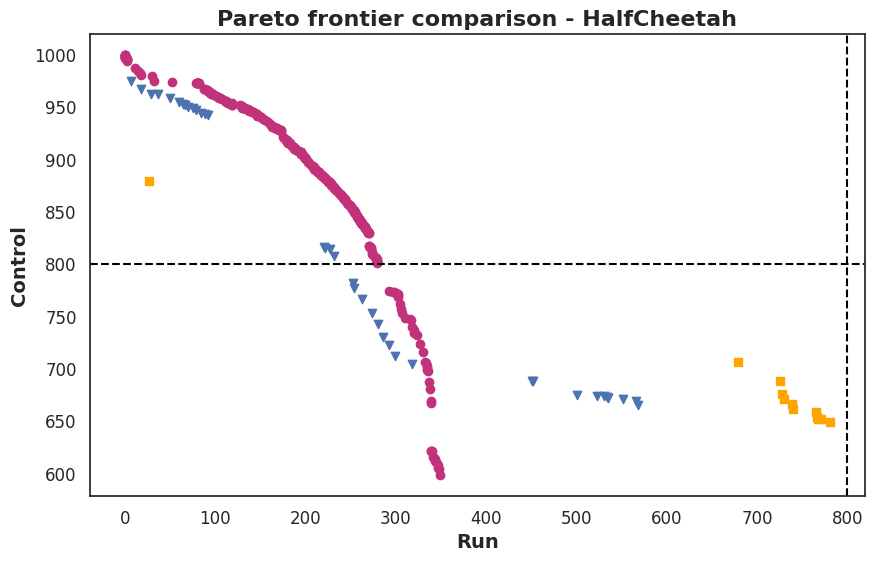

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(
    pgmorl_pareto["Run"],
    pgmorl_pareto["Control"],
    color="#C2327A",
    label="PGMoRL",
    marker="o",
)

plt.scatter(
    gpi_pareto["Run"],
    gpi_pareto["Control"],
    color="orange",
    label="GPI-LS",
    marker=",",
)

plt.scatter(
    dylam_pareto["Run"],
    dylam_pareto["Control"],
    label="DyLam",
    marker="v",
)

plt.axvline(x=800, color="black", linestyle="--")
plt.axhline(y=800, color="black", linestyle="--")
plt.xlabel("Run")
plt.ylabel("Control")
# plt.legend(prop=FONT)
plt.title("Pareto frontier comparison - HalfCheetah")
plt.savefig("HalfCheetah/halfcheetah_pareto.pdf", format="pdf", bbox_inches="tight")

In [19]:
ref_point = np.array([-1, -1])
hvs = {
    algo: (get_hv(values, ref_point), len(values))
    for algo, values in [
        ("PGMORL", pgmorl_pareto[["Run", "Control"]].values),
        ("GPI-LS", gpi_pareto[["Run", "Control"]].values),
        ("DyLam", dylam_pareto[["Run", "Control"]].values),
    ]
}
for algo, (hv, cardinality) in hvs.items():
    print(f"{algo} HV(log10): {np.log(hv)} | Cardinality: {cardinality}")

PGMORL HV(log10): 12.64873094309737 | Cardinality: 354
GPI-LS HV(log10): 13.224906092989455 | Cardinality: 12
DyLam HV(log10): 12.990697132545264 | Cardinality: 37


# MineCart

In [20]:
envelope_path = "minecart/envelope-pareto.csv"
gpils_path = "minecart/gpils-pareto.csv"
pcn_path = "minecart/pcn-pareto.csv"
ipro_dqn_path = "minecart/ipro-dqn-pareto.csv"
ipro_ppo_path = "minecart/ipro-ppo-pareto.csv"

In [21]:
gpi_pareto = pd.read_csv(gpils_path)

dylam_paths = [
    "minecart/dylam_objective_1.csv",
    "minecart/dylam_objective_2.csv",
    "minecart/dylam_objective_3.csv",
]
dylam_dfs = [pd.read_csv(path) for path in dylam_paths]
dylam = np.zeros((len(dylam_dfs[0]), len(dylam_dfs)))
for i, df in enumerate(dylam_dfs):
    dylam[:, i] = df.values[:, 1]

dylam_pareto = filter_pareto_dominated(dylam)

baseline_paths = [
    "minecart/baseline_objective_1.csv",
    "minecart/baseline_objective_2.csv",
    "minecart/baseline_objective_3.csv",
]
baseline_dfs = [pd.read_csv(path) for path in baseline_paths]
baseline = np.zeros((len(baseline_dfs[0]), len(baseline_dfs)))
for i, df in enumerate(baseline_dfs):
    baseline[:, i] = df.values[:, 1]

baseline_pareto = filter_pareto_dominated(baseline)

In [22]:
ref_point = np.array([-1, -1, -1000])
hvs = {
    algo: (get_hv(values, ref_point), len(values))
    for algo, values in [
        ("GPI-LS", gpi_pareto[["objective_1", "objective_2", "objective_3"]].values),
        ("DyLam", dylam_pareto),
    ]
}
for algo, (hv, cardinality) in hvs.items():
    print(f"{algo} HV(log10): {np.log(hv)} | Cardinality: {cardinality}")

GPI-LS HV(log10): 8.196497312305704 | Cardinality: 500
DyLam HV(log10): 8.714289123131962 | Cardinality: 32


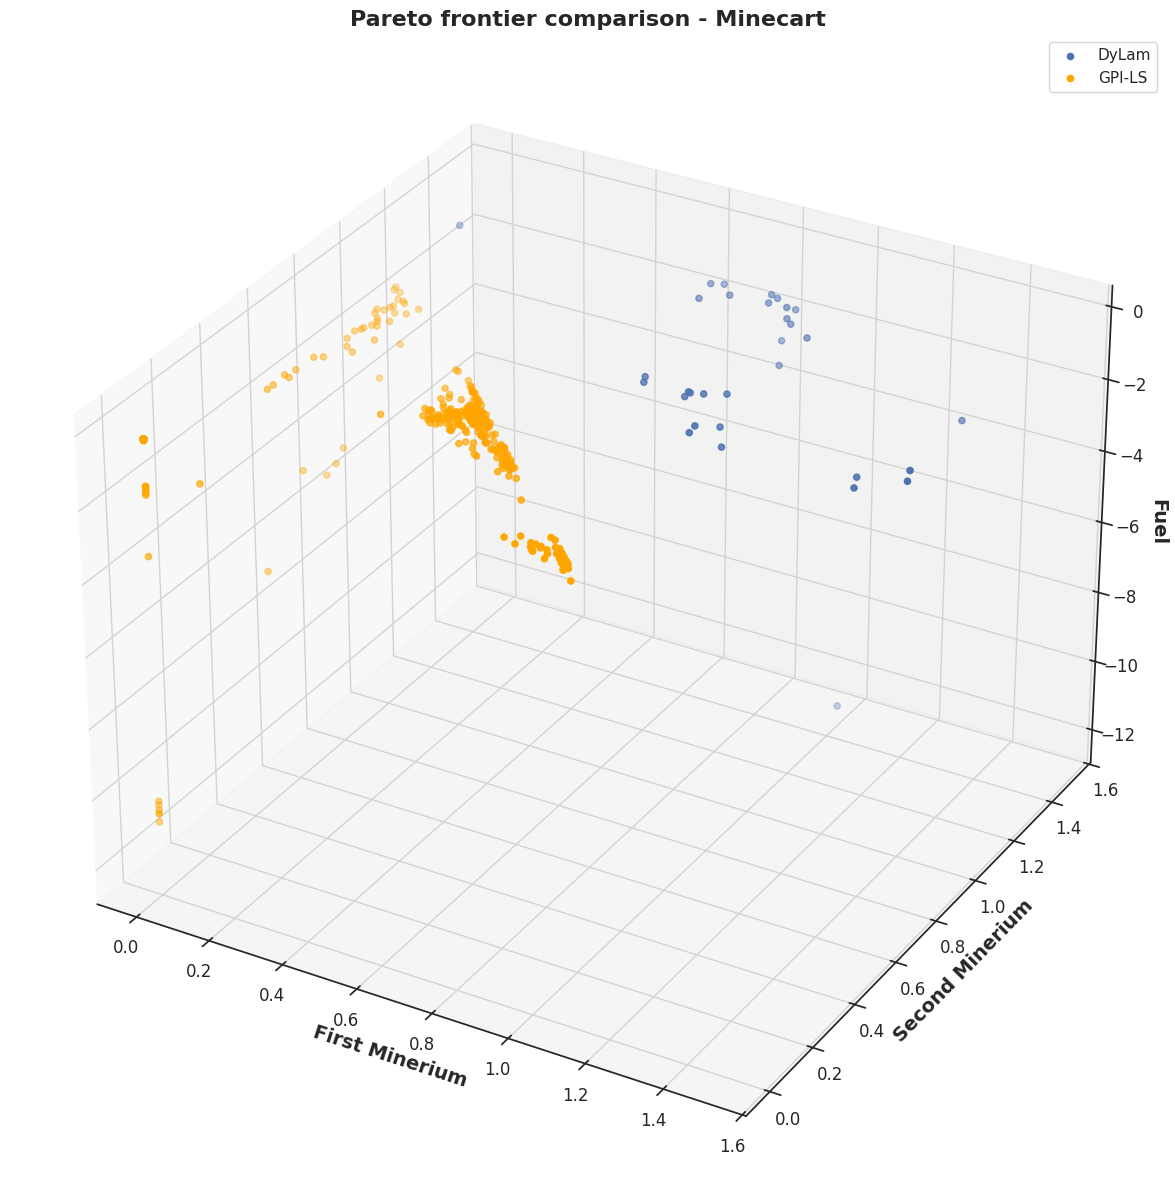

In [23]:
# Plot 3D DyLam data
ax = plt.figure(figsize=(15, 15)).add_subplot(projection="3d")
ax.set_xlabel("First Minerium")
ax.set_ylabel("Second Minerium")
ax.set_zlabel("Fuel", rotation=270)

ax.scatter(
    dylam_pareto[:, 0],
    dylam_pareto[:, 1],
    dylam_pareto[:, 2],
    c="b",
    marker="o",
    label="DyLam",
)

ax.scatter(
    gpi_pareto["objective_1"],
    gpi_pareto["objective_2"],
    gpi_pareto["objective_3"],
    c="orange",
    marker="o",
    label="GPI-LS",
)

plt.legend()
plt.title("Pareto frontier comparison - Minecart")
plt.savefig("minecart/minecart_pareto.pdf", format="pdf", bbox_inches="tight")

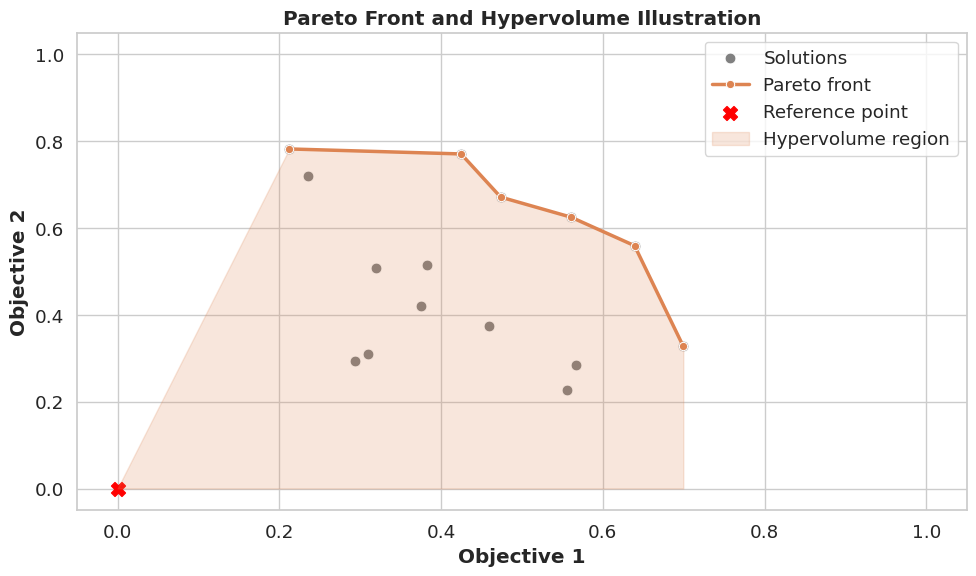

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Random reproducible data ---
np.random.seed(42)
points = np.random.rand(15, 2)
points[:, 0] = points[:, 0] * 0.6 + 0.2  # objective 1
points[:, 1] = points[:, 1] * 0.6 + 0.2  # objective 2


# --- Pareto front extraction (maximization) ---
def pareto_front_max(points):
    """Return non-dominated points (maximization)."""
    pareto = []
    for i, p in enumerate(points):
        # p is dominated if any other point is >= in all objectives and > in at least one
        if not np.any(np.all(points >= p, axis=1) & np.any(points > p, axis=1)):
            pareto.append(p)
    pareto = np.array(sorted(pareto, key=lambda x: x[0]))  # sort by first objective
    return pareto

pareto = pareto_front_max(points)

# --- Reference point for hypervolume (worse values for maximization) ---
ref_point = np.array([0.0, 0.0])

# --- Plot ---
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

# Scatter all points
sns.scatterplot(x=points[:, 0], y=points[:, 1], color="gray", s=60, label="Solutions")

# Pareto front line
sns.lineplot(x=pareto[:, 0], y=pareto[:, 1], marker="o", color="C1", linewidth=2.5, label="Pareto front")

# Reference point
plt.scatter(*ref_point, color="red", s=100, marker="X", label="Reference point")

# Hypervolume shading (area dominated by front towards reference point)
hv_x = np.concatenate(([ref_point[0]], pareto[:, 0], [pareto[-1, 0]]))
hv_y = np.concatenate(([ref_point[1]], pareto[:, 1], [ref_point[1]]))
plt.fill_between(hv_x, ref_point[1], hv_y, color="C1", alpha=0.2, label="Hypervolume region")

# --- Labels & aesthetics ---
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Pareto Front and Hypervolume Illustration")
plt.legend()
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()
